# NBA Symmetric Cell Degradation Experiment
## Install Dependencies

In [4]:
pip install numpy matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Clean / Smooth Out Anomalies in Data

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

file_path = 'data/sym001/sym001-2.txt'
df = pd.read_csv(file_path, sep='\t')
df.columns = df.columns.str.strip()

ANGLE_THRESHOLD = 10
OHM_THRESHOLD = 1.15

for cycle, group in df.groupby('cycle number'):
    #REMOVE CYCLES
    if cycle < 15:
        df = df[df['cycle number'] != cycle]
        continue

    # REMOVE ANOMALIES
    idxs = group.index
    for i in range(1, len(group) - 1):  # avoid edges
        # Phase angle values
        phase_cur = group['Phase(Z)/deg'].iloc[i]
        phase_prev = group['Phase(Z)/deg'].iloc[i - 1]
        phase_next = group['Phase(Z)/deg'].iloc[i + 1]

        # Impedance magnitude values
        z_cur = group['|Z|/Ohm'].iloc[i]
        z_prev = group['|Z|/Ohm'].iloc[i - 1]
        z_next = group['|Z|/Ohm'].iloc[i + 1]

        # Phase angle anomaly check
        if abs(phase_cur - phase_prev) > ANGLE_THRESHOLD or abs(phase_cur - phase_next) > ANGLE_THRESHOLD:
            df = df.drop(index=idxs[i])

        # Impedance magnitude anomaly check
        elif abs(z_cur / z_prev) > OHM_THRESHOLD or abs(z_cur / z_next) > OHM_THRESHOLD:
            df = df.drop(index=idxs[i])

## Bode Impedance Graph (|Z| & Phase Angle vs Frequency)

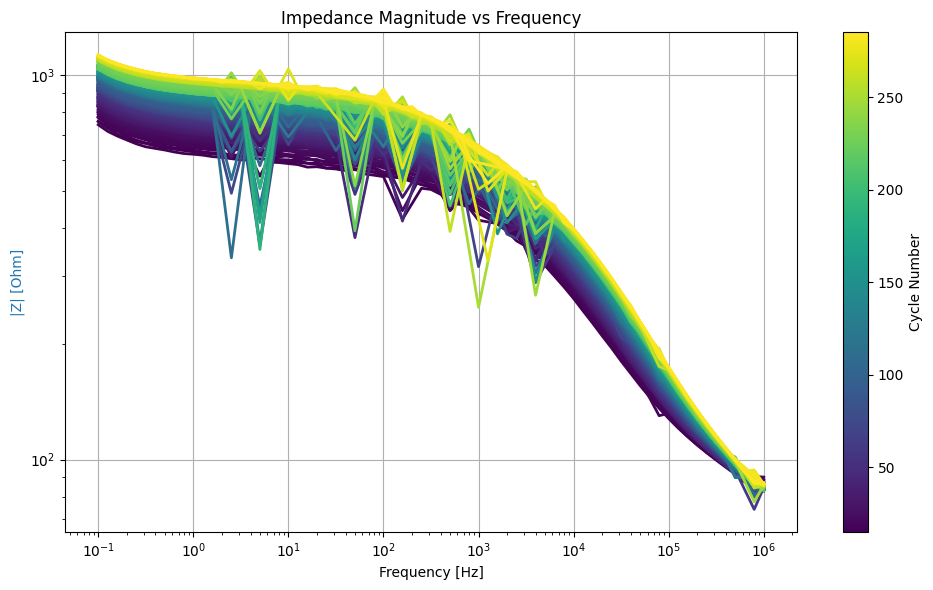

In [197]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# |z|
color1 = 'tab:blue'
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('|Z| [Ohm]', color=color1)
cmap = plt.cm.viridis
norm = plt.Normalize(df['cycle number'].min(), df['cycle number'].max())
for cycle, group in df.groupby('cycle number'):
    x = group['freq/Hz']
    y = group['|Z|/Ohm']
    ax1.plot(x, y, color=cmap(norm(cycle)), linewidth=2)
ax1.set_yscale('log')


# phase
# ax2 = ax1.twinx()
# color2 = 'tab:red'
# ax2.set_ylabel('Phase(Z) [deg]', color=color2)

# for cycle, group in df.groupby('cycle number'):
#     x = group['freq/Hz']
#     y = group['Phase(Z)/deg']
#     ax2.plot(x, y, color=cmap(norm(cycle)), linewidth=2)

# ax2.hlines(y=-45, xmin=df['freq/Hz'].min(), xmax=df['freq/Hz'].max(),
#            colors='gray', linestyles='--', label='Phase = 45°')

#Colorbar
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Cycle Number')

ax1.set_xscale('log')
plt.title('Impedance Magnitude vs Frequency')
fig.tight_layout()
plt.grid(True)
plt.show()

## Nyquist Impedance Graph

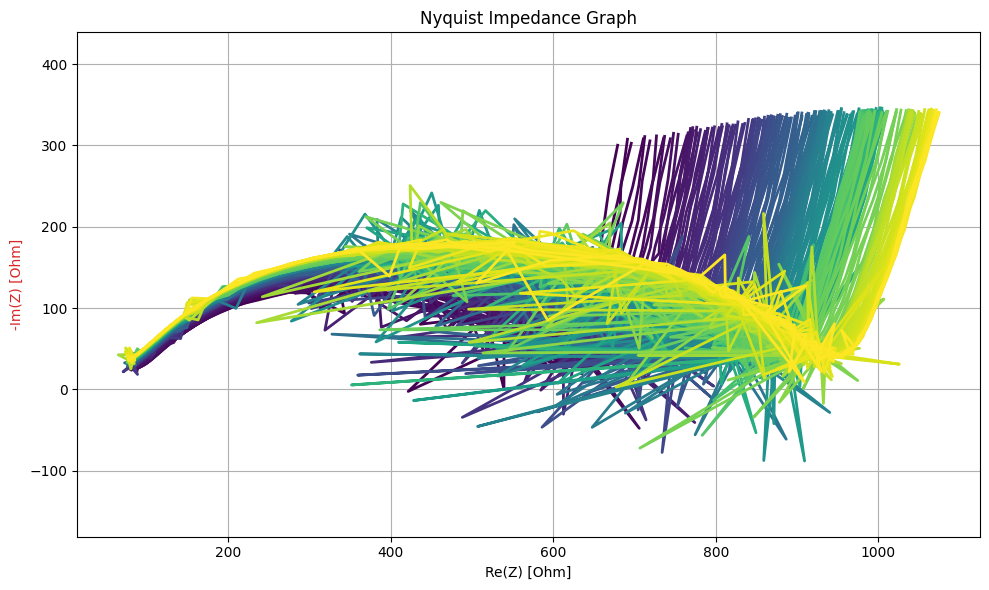

In [192]:
plt.figure(figsize=(10, 6))

plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Im(Z) [Ohm]', color='tab:red')

cmap = plt.cm.viridis
norm = mcolors.Normalize(df['cycle number'].min(), df['cycle number'].max())

for cycle, group in df.groupby('cycle number'):
    x = group['Re(Z)/Ohm']
    y = group['-Im(Z)/Ohm']
    plt.plot(x, y, color=cmap(norm(cycle)), linewidth=2)

plt.axis('equal')
plt.title('Nyquist Impedance Graph')
plt.grid(True)
plt.tight_layout()
plt.show()

## Frequency vs Time

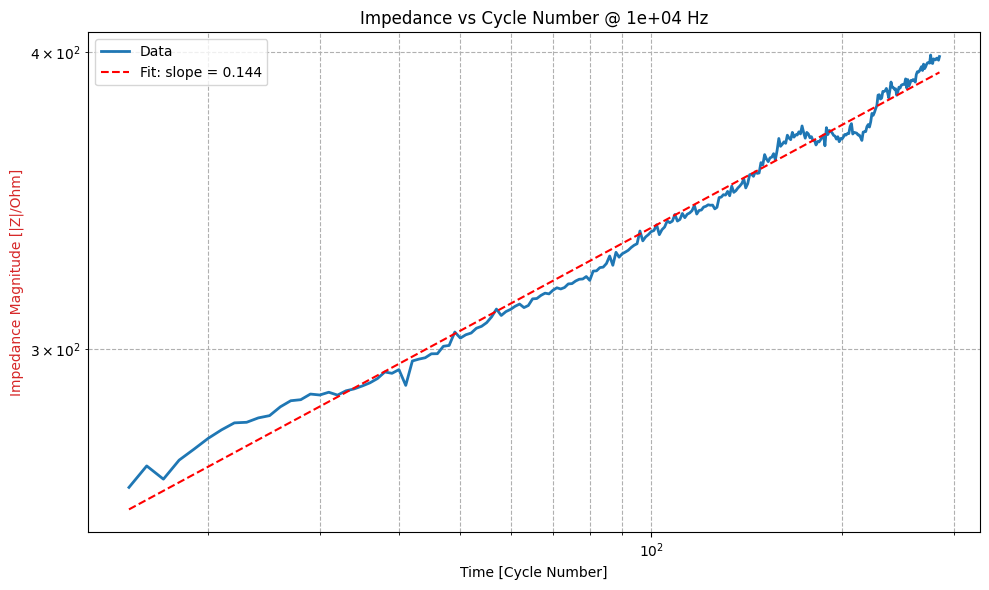

In [196]:
SELECT_FREQUENCY = 10**4
EPISOLON = 2.5

plt.figure(figsize=(10, 6))

plt.xlabel('Time [Cycle Number]')
plt.ylabel('Impedance Magnitude [|Z|/Ohm]', color='tab:red')

df_frequency = df[abs(df['freq/Hz'] - SELECT_FREQUENCY) < EPISOLON]

# Remove zeros or negatives before log (log undefined for these)
df_frequency = df_frequency[(df_frequency['cycle number'] > 0) & (
    df_frequency['|Z|/Ohm'] > 0)]

x = df_frequency['cycle number']
y = df_frequency['|Z|/Ohm']

plt.plot(x, y, color='tab:blue', linewidth=2, label='Data')

plt.xscale('log')
plt.yscale('log')

#Calculate Slope of Best Fit Line
log_x = np.log10(x)
log_y = np.log10(y)

m, b = np.polyfit(log_x, log_y, 1)
fit_y = 10**(b) * x**m
plt.plot(x, fit_y, 'r--', label=f'Fit: slope = {m:.3f}')

plt.title(f'Impedance vs Cycle Number @ {SELECT_FREQUENCY:.0e} Hz')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()